In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGT', motives=None, motif_length=6, 
                            sequence_length=100, n_sequences=1000, n_motives=2, p=0.2,
                           random_state=1):
    random.seed(random_state)
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
    
    sequence_length = sequence_length / len(motives)
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences

    counter=0
    seqs=[]
    for i in range(n_seq_per_motif):
        total_seq = ''
        total_binary_seq=''
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            total_seq += seq
        seqs.append(('ID%d'%counter,total_seq))
        counter += 1
    binary_skeleton = '0' * flanking_length + '1' * motif_length + '0' * flanking_length
    binary_seq = binary_skeleton * n_motives
    return motives, seqs, binary_seq

In [3]:
from utilities import Weblogo
from IPython.display import Image, display

In [4]:
from sklearn.cluster import KMeans
from eden_wrapper import EdenWrapper
from meme_wrapper import Meme
from smod_wrapper import SMoDWrapper

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [6]:

def score_seqs(seqs, n_motives, tool):
    scores = []
    if tool is None:
        return scores
    
    for j in range(len(seqs)):
        seq_scr = [] 
        iters = tool.nmotifs
        for k in range(iters):
            scr=tool.score(motif_num=k+1, seq=seqs[j][1])
            seq_scr.append(scr)

        # taking average over all motives for a sequence
        if len(seq_scr) > 1:
            x = np.array(seq_scr[0])
            for l in range(1, iters):
                x = np.vstack((x, seq_scr[l]))
            seq_scr = list(np.mean(x, axis=0))
            scores.append(seq_scr)
        elif len(seq_scr) == 1:
            scores.append(np.array(seq_scr[0]))
        else:
            raise ValueError("no sequence score")

    return scores

def exp_noise(noise_level=0.1):
    #setup parameters
    alphabet='ACGT'
    sequence_length=40
    n_sequences=20
    p=noise_level
    n_motives = 2
    motif_length = 10


    #make dataset
    motives, seqs, binary_seq = make_artificial_dataset(alphabet=alphabet,
                                            #motives=motives,
                                            n_motives = n_motives,
                                            motif_length = motif_length,
                                            sequence_length=sequence_length,
                                            n_sequences=n_sequences,
                                            p=p,
                                            random_state=8)
    print "Sequence Logo for whole dataset:"
    img = Weblogo().create_logo(seqs)
    display(Image(img))
    true_score = [float(int(i)) for i in binary_seq]

    tool = SMoDWrapper(scoring_criteria = 'pwm',
                       #complexity = complexity,
                       #n_clusters = n_clusters,
                       min_subarray_size = 8,
                       max_subarray_size = 12,
                       pos_block_size = 10,
                       neg_block_size = 10,
                       clusterer = KMeans(),
                       min_score = 7,
                       min_freq = 0.69,
                       min_cluster_size = 1,
                       similarity_th = 0.5,
                       freq_th = 0.69,
                       p_value=1,
                       regex_th=0.92,
                       #sample_size=sample_size,
                       std_th=0.48,
                       
                       threshold=1e-25,
                       pseudocounts=0.01,
                       
                       weblogo_obj = Weblogo(units='probability')
                       )
    from eden.modifier.seq import seq_to_seq, shuffle_modifier
    neg_seqs = seq_to_seq(seqs, modifier=shuffle_modifier, times=1, order=2)
    neg_seqs = list(neg_seqs)

    block_size=n_sequences/8

    pos_size = len(seqs)
    train_pos_seqs = seqs[:pos_size/2]
    test_pos_seqs = seqs[pos_size/2:]

    neg_size = len(neg_seqs)
    train_neg_seqs = neg_seqs[:neg_size/2]
    test_neg_seqs = neg_seqs[neg_size/2:]
    
    tool.fit(seqs, neg_seqs)
    #tool.display_logo(motif_num=1)
    #tool.display(motif_num=1)


    total_sig = np.zeros(sequence_length)
    total_sig_log = np.zeros(sequence_length)
    for j in range(len(motives)):
        sig = np.zeros(sequence_length)
        for i in range(len(seqs)):
            score = tool.score(motif_num=j+1, seq=seqs[i][1])
            sig += np.array(score)
            total_sig += np.array(score)
            total_sig_log += np.log(score)
        #sig /= float(len(seqs))
        #sig *= len(motives)
        plt.figure(figsize=(16,3))
        plt.title("Score Signal For Motif " + str(j+1))
        plt.fill_between(range(len(sig)), 0, sig, alpha=0.3)
        plt.show()
    
    total_sig /= float(len(seqs))
    plt.figure(figsize=(16,3))
    plt.fill_between(range(len(total_sig)), 0, total_sig, alpha=0.3)
    plt.yscale('log', nonposy='clip')
    plt.title("Average for all motives")
    plt.show()
    
    # Computing ROC
    scores = score_seqs(seqs=test_pos_seqs, n_motives=len(motives), tool=tool)
    
    mean_score = np.mean(scores, axis=0)
    roc_score = roc_auc_score(true_score, mean_score)
    print "ROC_original:", roc_score
    print "ROC_total_sig:", roc_auc_score(true_score, total_sig)


At noise level: 0.1
Sequence Logo for whole dataset:


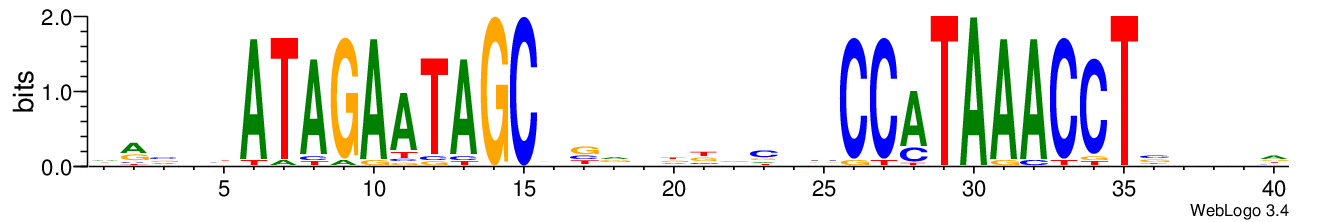

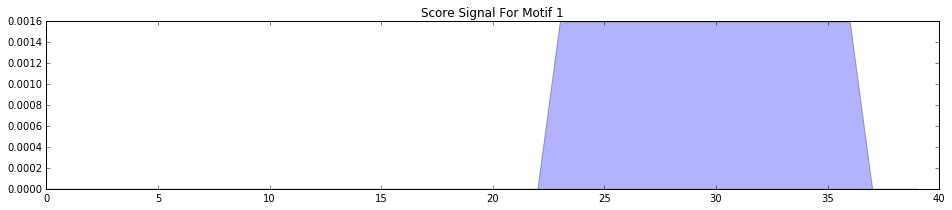

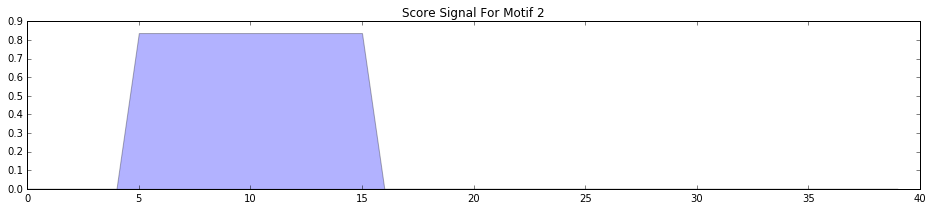

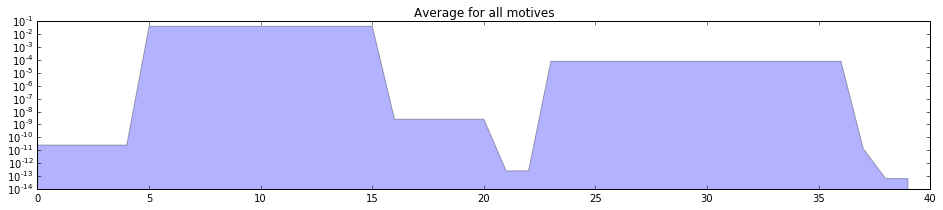

ROC_original: 0.9125
ROC_total_sig: 0.9125

At noise level: 0.2
Sequence Logo for whole dataset:


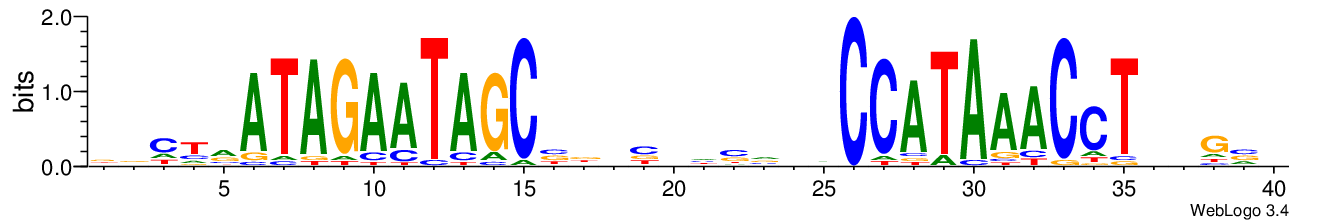

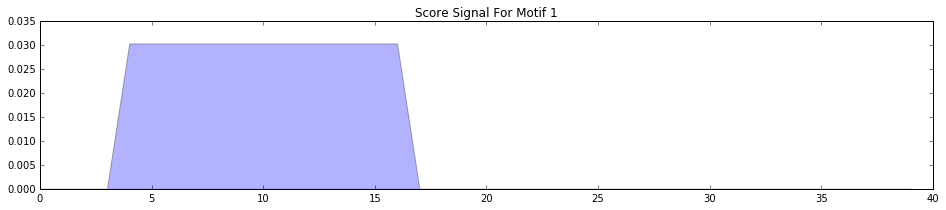

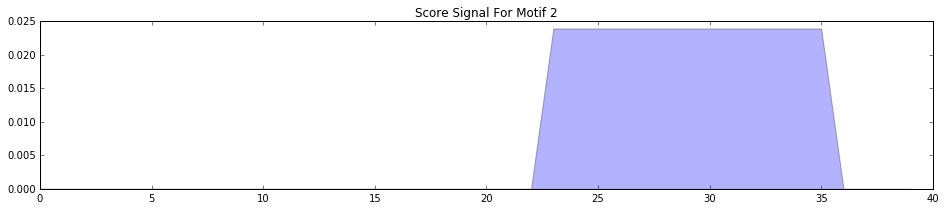

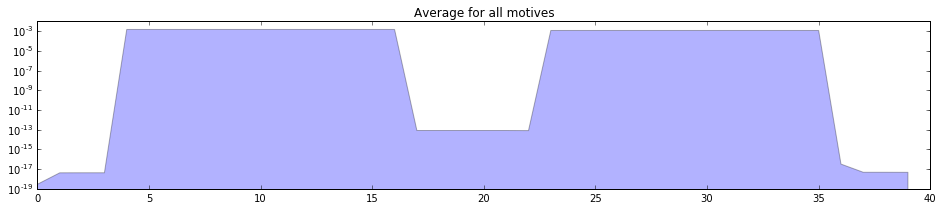

ROC_original: 0.85
ROC_total_sig: 0.85

At noise level: 0.3
Sequence Logo for whole dataset:


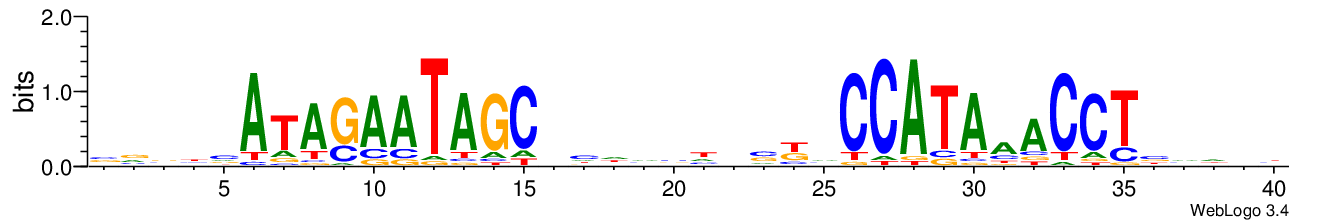

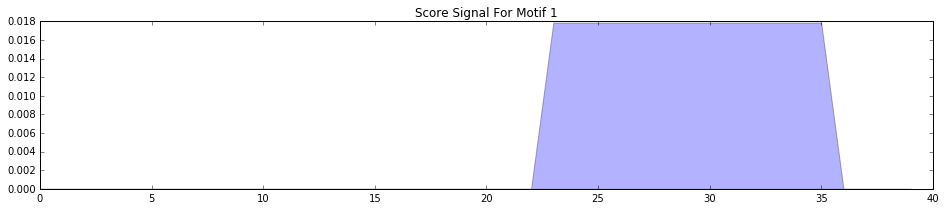

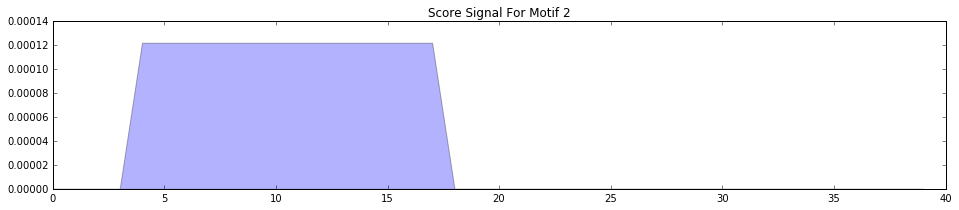

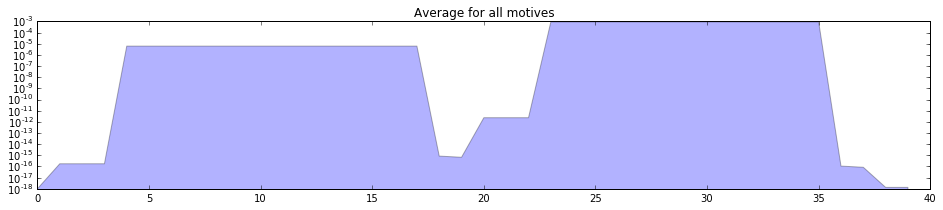

ROC_original: 0.8375
ROC_total_sig: 0.8375

At noise level: 0.4
Sequence Logo for whole dataset:


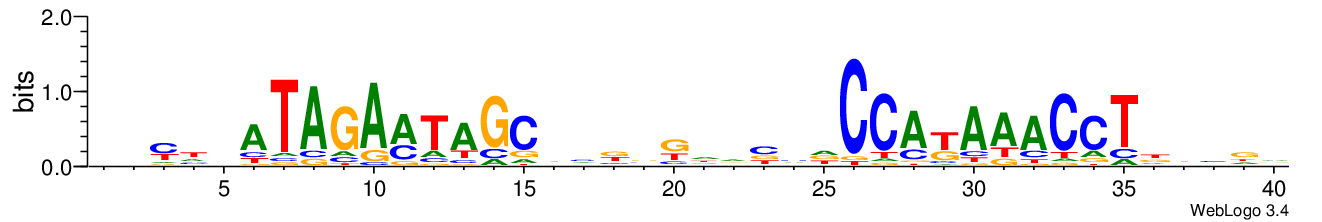

/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


no motives found...

At noise level: 0.5
Sequence Logo for whole dataset:


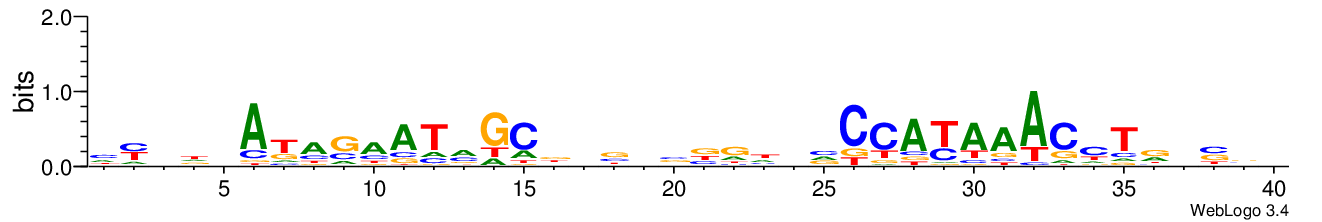

no motives found...

At noise level: 0.6
Sequence Logo for whole dataset:


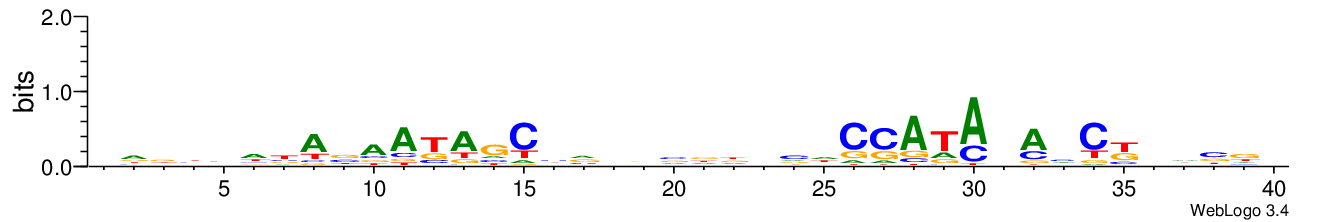

no motives found...

At noise level: 0.7
Sequence Logo for whole dataset:


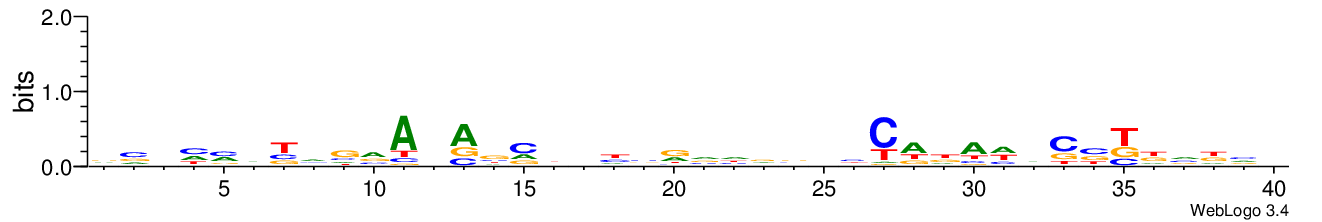

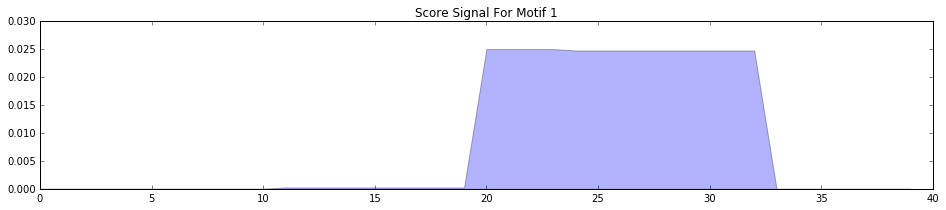

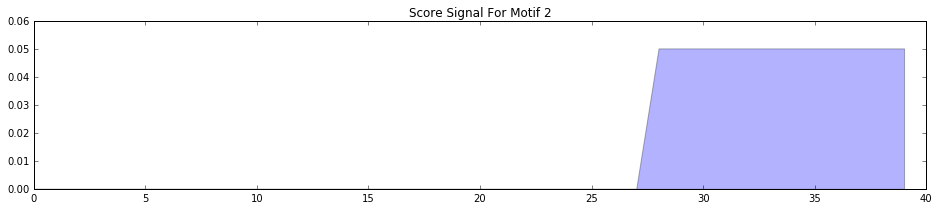

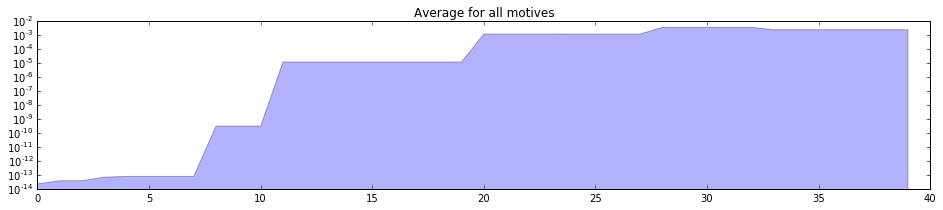

ROC_original: 0.575
ROC_total_sig: 0.52875

At noise level: 0.8
Sequence Logo for whole dataset:


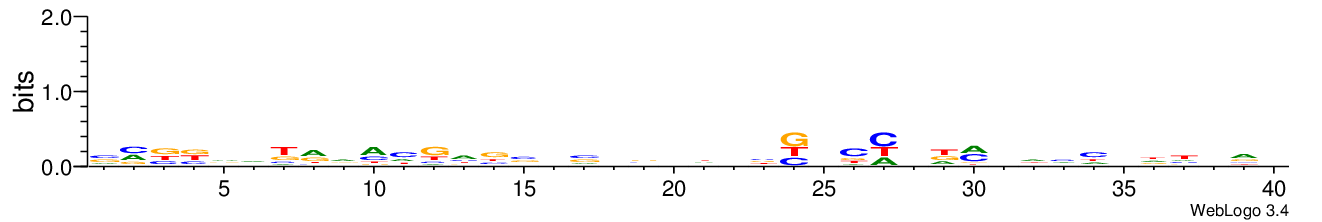

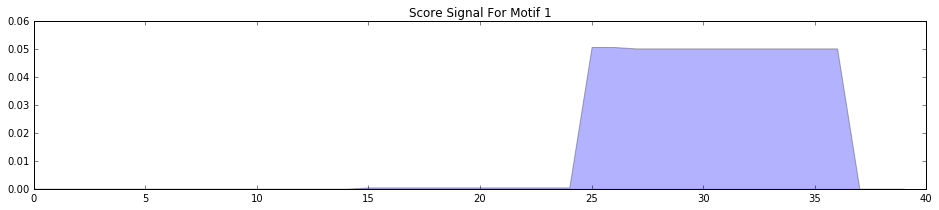

no motives found...
CPU times: user 27.4 s, sys: 2.46 s, total: 29.9 s
Wall time: 17.9 s


In [7]:
%%time
%matplotlib inline
    

for i in [x/float(10) for x in range(1,9)]:
    print "\nAt noise level:", i
    try:
        exp_noise(noise_level=i)
    except (AttributeError, IndexError):
        print "no motives found..."
        continue